# House Price Prediction with Machine Learning

## Problem Statement
Accurately predicting house prices is important for real estate platforms, investors, and buyers.  
The goal of this project is to build a regression model that estimates house prices based on structural and location features such as size, age, and distance to the city center.

This notebook demonstrates an end-to-end machine learning workflow including:
- Data exploration
- Feature engineering
- Model pipelines
- Cross-validation
- Model comparison
- Interpretation of results

The focus is not only performance, but also reproducibility and good ML practices.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

sns.set_style("whitegrid")

In [5]:
df = pd.read_csv("../data/house_prices.csv")
df.head()

,size,bedrooms,bathrooms,floors,age,distance_to_center,has_garage,has_pool,price
0,165.2,3,1,3,47,12.82,1,0,530.74
1,98.0,2,3,3,19,10.57,1,1,434.33
2,187.5,4,1,1,40,11.65,0,1,570.58
3,197.0,1,3,3,19,13.89,0,0,645.76
4,52.4,2,3,2,39,5.95,1,0,173.38


## Dataset

The dataset contains residential property information including:
- Size (m²)
- Age of the property
- Distance to city center
- Target variable: price

Inspecting structure, missing values, and basic statistics.

In [6]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   size                500 non-null    float64
 1   bedrooms            500 non-null    int64  
 2   bathrooms           500 non-null    int64  
 3   floors              500 non-null    int64  
 4   age                 500 non-null    int64  
 5   distance_to_center  500 non-null    float64
 6   has_garage          500 non-null    int64  
 7   has_pool            500 non-null    int64  
 8   price               500 non-null    float64
dtypes: float64(3), int64(6)
memory usage: 35.3 KB


,size,bedrooms,bathrooms,floors,age,distance_to_center,has_garage,has_pool,price
count,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,149.41320,3.014000,2.476000,1.966000,25.262000,9.243700,0.476000,0.500000,560.663140
std,47.82874,1.404903,1.126037,0.825959,14.501101,4.844756,0.499924,0.500501,183.712328
min,40.00000,1.000000,1.000000,1.000000,0.000000,0.500000,0.000000,0.000000,70.760000
25%,116.62500,2.000000,1.000000,1.000000,13.000000,5.915000,0.000000,0.000000,420.742500
50%,150.15000,3.000000,2.000000,2.000000,25.000000,9.285000,0.000000,0.500000,562.255000
75%,179.35000,4.000000,3.000000,3.000000,38.000000,12.577500,1.000000,1.000000,682.840000
max,295.70000,5.000000,4.000000,3.000000,49.000000,24.570000,1.000000,1.000000,1111.600000


In [7]:
df.isna().sum()

size                  0
bedrooms              0
bathrooms             0
floors                0
age                   0
distance_to_center    0
has_garage            0
has_pool              0
price                 0
dtype: int64

## Exploratory Data Analysis

Exploring distributions and relationships between features and price to understand trends, outliers, and correlations.

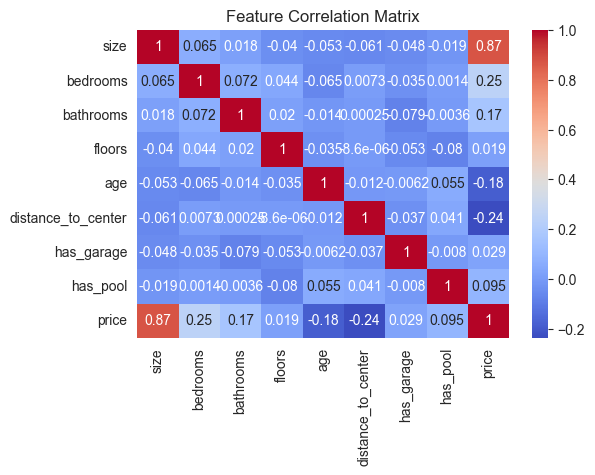

In [9]:
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

## Feature/Target split

I will now separate predictors and target and create a reproducible train/test split.

In [ ]:
X = df.drop(columns=["price"])
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)



## Modeling Strategy

I will use sklearn Pipelines to avoid data leakage and ensure that preprocessing is applied consistently during training and inference.

Several models are evaluated:
- Linear Regression
- Ridge Regression
- Lasso Regression
- Random Forest

In [11]:
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42)
}

results = []


## Cross-validation

Cross-validation allows me to estimate generalization performance and compare models fairly.

In [12]:
for name, model in models.items():
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])
    
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="r2")
    
    results.append({
        "Model": name,
        "CV_R2_Mean": cv_scores.mean(),
        "CV_R2_Std": cv_scores.std()
    })

cv_results = pd.DataFrame(results)
cv_results

,Model,CV_R2_Mean,CV_R2_Std
0,Linear,0.880456,0.024902
1,Ridge,0.880475,0.024686
2,Lasso,0.880457,0.024894
3,RandomForest,0.822155,0.023401


## Training best model

In [13]:
best_model_name = cv_results.sort_values("CV_R2_Mean", ascending=False).iloc[0]["Model"]
best_model = models[best_model_name]

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", best_model)
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

## Evaluation

I will evaluate using:
- MAE (average absolute error)
- RMSE (penalizes large errors)
- R² (explained variance)

These metrics help quantify model usefulness in a real-world scenario.

In [19]:
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, rmse, r2

(51.08103477476528, 63.112026923045434, 0.87827370063654)

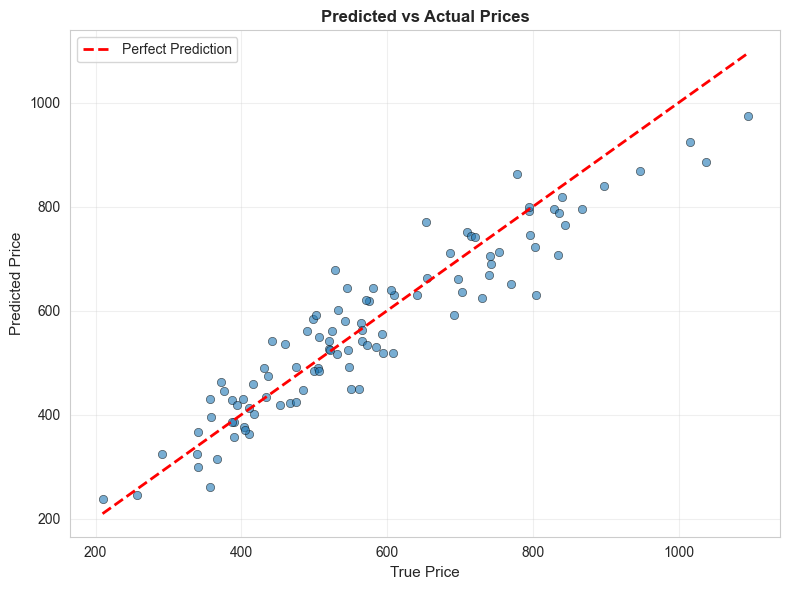

In [ ]:
plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('True Price', fontsize=11)
plt.ylabel('Predicted Price', fontsize=11)
plt.title('Predicted vs Actual Prices', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Feature Importance

Helps interpret which variables drive pricing the most.

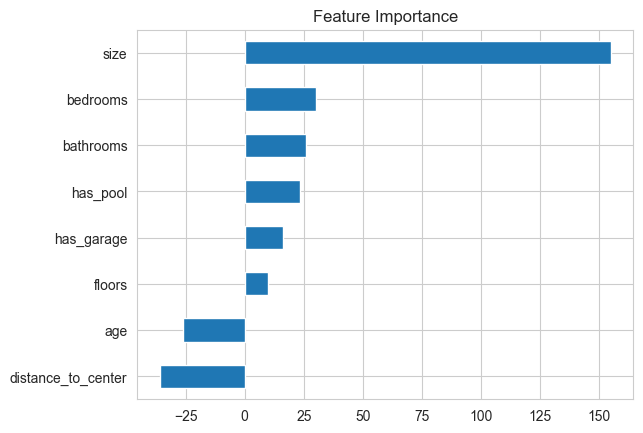

In [27]:
if best_model_name in ["Linear", "Ridge", "Lasso"]:
    coefs = pipe.named_steps["model"].coef_
    pd.Series(coefs, index=X.columns).sort_values().plot(kind="barh")
    plt.title("Feature Importance")
    plt.show()

## Conclusion

This project demonstrated an end-to-end regression pipeline for predicting house prices.

Key takeaways:
- Pipelines prevent data leakage and improve reproducibility.
- Cross-validation provides reliable performance estimates.
- Regularized models help control overfitting.
- Feature importance allows interpretability.

Future improvements:
- Add more location-based features.
- Include non-linear models like XGBoost.
- Deploy model as an API or Streamlit app.